# **East Africa drought study - data preprocessing**

In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *

# for SPEI fitting
import lmoments3.distr                     # pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo") 

# load shapefile used to extract time series from gridded data
sf = gpd.read_file("sf_gha")

---
## **Covariates**

_4-year smoothed GMST, Nino3.4 and SSTs all downloaded from Climate Explorer during March 2023_

### **GMST**

In [35]:
gmst = pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year")

# create CSV with headers for upload to Climate Explorer

csv_fnm = "ts/EA-drought_gmst-smoothed.dat"
str1 = "# contact :: smoothed GMST - East Africa drought 2023, c.barnes22@imperial.ac.uk"
str2 = "# gmst [decC] April 2023 snapshot of giss_al_gl_m_4yrlo from KNMI Climate Explorer at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year gmst"

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

gmst.to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Detrended Nino index**

In [36]:
# get detrended Nino index from indices on Climate Explorer
nino = decode_times(xr.open_dataset("data/iersst_nino3.4a.nc", decode_times = False))["Nino3.4"]
sst = decode_times(xr.open_dataset("data/iersstv5_0-360E_-20-20N_n_su.nc", decode_times = False)).sst
nino_detrended = (nino - (sst - sst.sel(time = slice("1980", "2010")).mean())).rename("nino_dt")

nino_ond = nino_detrended.rolling(time = 3, center = False).mean().groupby("time.month")[12].dropna("time", "any")
nino_ond = nino_ond.assign_coords(time = nino_ond.time.dt.year).to_dataframe()

In [38]:
# create CSV with headers for upload to Climate Explorer

csv_fnm = "ts/EA-drought_detrended-nino-ond.dat"
str1 = "# contact :: mean detrended Nino3.4 index for OND - East Africa drought 2023, c.barnes22@imperial.ac.uk"
str2 = "# nino34 [degC] April 2023 snapshot of iersst_nino3.4a detrended with iersstv5_0-360E_-20-20N_n_su from KNMI Climate Explorer at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year nino34"

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

nino_ond.to_csv(csv_fnm, sep = " ", mode = "a", header = False)

---
## **Gridded observations**

### **CPC**

#### **Precip**

In [92]:
# load daily CPC precip, resample to monthly
pr_cpc = xr.open_mfdataset("../../Data/cpc/precip.*.nc").sel(lon = slice(28,54), lat = slice(18,-15), time = slice(None, "2022")).precip

# get monthly time series of mean precip over study region
pr_cpc_ts = pr_cpc.where(regionmask.mask_3D_geopandas(sf, pr_cpc.lon, pr_cpc.lat).squeeze(drop = True) == 1).mean(["lat", "lon"])
pr_cpc_ts.to_netcdf("data/cpc_pr_ts-daily.nc")

# seasonal cycle
pr_cpc_ts.groupby("time.dayofyear").mean().to_netcdf("data/cpc_pr_seasonal.nc")

# spatial patterns
pr_cpc.sel(time = [m in [3,4,5] for m in pr_cpc.time.dt.month]).mean("time").to_netcdf("data/cpc_pr-mam_spatial.nc")
pr_cpc.sel(time = [m in [10,11,12] for m in pr_cpc.time.dt.month]).mean("time").to_netcdf("data/cpc_pr-ond_spatial.nc")

In [ ]:
## TIME SERIES FOR CLIMATE EXPLORER

for season in ["mam", "ond", "24"]:
    
    # get accumulated precip for required period
    if season == "mam":
        pr = pr_cpc_ts.rolling(time = 3).sum().groupby("time.month")[5]
    elif season == "ond":
        pr = pr_cpc_ts.rolling(time = 3).sum().groupby("time.month")[12]
    elif season == "24":
        pr = pr_cpc_ts.rolling(time = 24).sum().groupby("time.month")[12]
        
    # determine filename & text strings    
    s_string = {"mam" : "MAM", "ond" : "OND", "24" : "24m accumulated"}[season]
    s_str2 = {"mam" : "MAM", "ond" : "OND", "24" : "2-year"}[season]
                    
    csv_fnm = "ts/EA-drought_pr-"+season+"_cpc.dat"
    if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
    
    #create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CPC "+s_string+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr_"+season+" [mm] "+s_str2+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr_"+season
    
    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    pr.assign_coords(time = pr.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **PET**

In [93]:
# load daily temperatures
tmin, tmax = [xr.open_dataset("data/cpc_"+varnm+".nc").sel(lon = slice(28,54), lat = slice(18,-15), time = slice(None, "2022"))[varnm] for varnm in ["tmin", "tmax"]]

# use mean temperature to validate seasonal & spatial characteristics
tas = (tmax + tmin) / 2
tas.where(regionmask.mask_3D_geopandas(sf, tas.lon, tas.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.dayofyear").mean().to_netcdf("data/cpc_tas_seasonal.nc")
tas.mean("time").to_netcdf("data/cpc_tas_spatial.nc")

In [94]:
# Compute PET using Thornthwaite equation
pet = convert_units_to(potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = "thornthwaite48"), "mm/month").rename("pet")
pet_ts = pet.where(regionmask.mask_3D_geopandas(sf, pet.lon, pet.lat).squeeze(drop = True) == 1).mean(["lat", "lon"])
pet_ts.to_netcdf("data/cpc_pet_ts-monthly.nc")

In [48]:
## TIME SERIES FOR CLIMATE EXPLORER

csv_fnm = "ts/EA-drought_pet-24_cpc.dat"
if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)

#create extra header lines for upload to Climate Explorer 
str1 = "# contact :: CPC 24-month accumulated PET - East Africa drought 2023, c.barnes22@imperial.ac.uk"
str2 = "# pet_24 [mm] 2-year accumulated potential evapotranspiration (Thornthwaite) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year pet_24"

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

pet24 = pet_ts.rolling(time = 24).sum().groupby("time.month")[12]
pet24.assign_coords(time = pet24.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **SPEI**

In [8]:
# load data
epr = pd.merge(pd.read_csv("ts/EA-drought_pr-24_cpc.dat", comment = "#", sep = " ", header = None, names = ["year", "pr"], index_col = "year"),
               pd.read_csv("ts/EA-drought_pet-24_cpc.dat", comment = "#", sep = " ", header = None, names = ["year", "pet"], index_col = "year"),
               left_index = True, right_index = True)

epr["eff_pr"] = epr.pr - epr.pet

# quick check that the units look right - expect PET to be about 3-4 times PR
print("Ratio PET/PR:", int(epr.pet.mean() / epr.pr.mean()))

Ratio PET/PR: 4


In [9]:
# compute SPEI
spei_pars = glo.lmom_fit(epr.loc[slice("1980", "2010"), "eff_pr"].copy())
spei24 = norm.ppf(glo.cdf(epr.eff_pr, *spei_pars.values()))

In [10]:
## TIME SERIES FOR CLIMATE EXPLORER

csv_fnm = "ts/EA-drought_spei-24_cpc.dat"
if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: CPC 24-month SPEI - East Africa drought 2023, c.barnes22@imperial.ac.uk"
str2 = "# spei_24 [mm] accumulated standardised precipitation-evapotranspiration index at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year spei24"

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

pd.DataFrame({"year" : epr.index, "spei" : spei24}).set_index("year").to_csv(csv_fnm, sep = " ", mode = "a", header = False)

---
### **CenTrends + CHIRPS**
_Blended dataset downloaded from Climate Explorer_

#### **Precip**

In [4]:
# load monthly Centrends/CHIRPS precip
centrends = convert_units_to(decode_times(xr.open_dataset("data/centrends_chirps_28-54E_-15-18N.nc", decode_times = False)).precip.sel(time = slice(None, "2022")), "mm/month")

centrends_ts = centrends.where(regionmask.mask_3D_geopandas(sf, centrends.lon, centrends.lat).squeeze(drop = True) == 1).mean(["lat", "lon"])

# spatial patterns
centrends.sel(time = [m in [3,4,5] for m in centrends.time.dt.month]).mean("time").to_netcdf("data/ctchirps_pr-mam_spatial.nc")
centrends.sel(time = [m in [10,11,12] for m in centrends.time.dt.month]).mean("time").to_netcdf("data/ctchirps_pr-ond_spatial.nc")

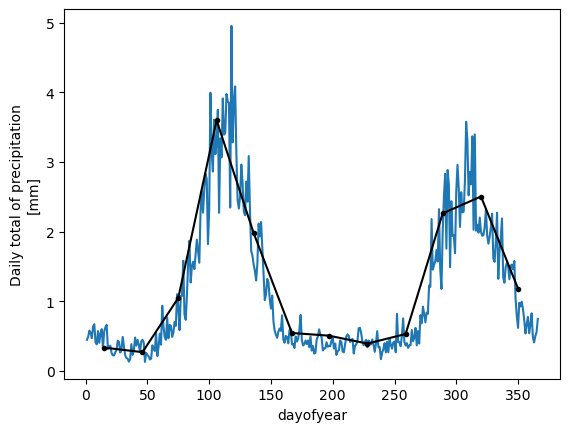

In [16]:
# visual check of seasonal cycle against CPC (matches, so can just use daily CPC to validate models)
cpc_sc = xr.open_dataset("data/cpc_pr_seasonal.nc").precip

centrends_sc = centrends_ts.sel(time = slice("1980", "2022")).groupby("time.month").mean()

cpc_sc.plot(label = "CPC")
plt.gca().plot([datetime(2020,int(m),15).timetuple().tm_yday for m in centrends_sc.month], convert_units_to(centrends_sc, "mm/day"), color = "k", label = "CHIRPS", marker = ".")

In [5]:
## TIME SERIES FOR CLIMATE EXPLORER

for season in ["mam", "ond", "24"]:
    
    # get accumulated precip for required period
    if season == "mam":
        pr = centrends_ts.rolling(time = 3).sum().groupby("time.month")[5]
    elif season == "ond":
        pr = centrends_ts.rolling(time = 3).sum().groupby("time.month")[12]
    elif season == "24":
        pr = centrends_ts.rolling(time = 24).sum().groupby("time.month")[12]
        
    # determine filename & text strings    
    s_string = {"mam" : "MAM", "ond" : "OND", "24" : "24m accumulated"}[season]
    s_str2 = {"mam" : "MAM", "ond" : "OND", "24" : "2-year"}[season]
                    
    csv_fnm = "ts/EA-drought_pr-"+season+"_chirps05+centrends01.dat"
    if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
    
    #create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CenTrends 0.1deg + CHIRPS 0.5deg 12m "+s_string+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr_"+season+" [mm] "+s_str2+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr_"+season
    
    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    pr.assign_coords(time = pr.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

## **Models**

### **CORDEX**

#### **GMST**
_CMIP5 global mean temperatures (tas) downloaded from Climate Explorer_

In [124]:
# Copy CMIP5 GMST files across
for gcm in list(set(["_rcp85_".join(cordex_model(fnm).split("_")[:2]) for fnm in glob.glob("cordex/pr_*.nc")])):
    
    gsat_fnm = glob.glob("../00_gsat/cmip5_smoothed-gsat*"+gcm+".dat")
    print(gsat_fnm)
    
    if len(gsat_fnm) == 0:
        print("No GSAT:", gcm)
        continue

    gsat_fnm = gsat_fnm[0]
    new_fnm = "ts/EA-drought_"+re.sub(".+Amon", "gsat", gsat_fnm.split("/")[-1])
    if len(new_fnm.split("/")[-1]) > 65: print("Filename too long:", new_fnm)
    
    ! cp $gsat_fnm $new_fnm

#### **Detrended Nino3.4 index**
_Nino3.4 index & tropical SSTs downloaded from Climate Explorer_

In [219]:
# compute OND Nino index
for gcm in list(set(["_rcp85_".join(cordex_model(fnm).split("_")[:2]) for fnm in glob.glob("cordex/pr_*.nc")])):
    
    nino_fnm = glob.glob("../10_nino-detrended/cmip5_nino-detrended_"+gcm+".dat")
    if len(nino_fnm) == 0:
        print("No Nino:", gcm)
        continue
    print(nino_fnm)

    nino = pd.read_csv(nino_fnm[0], comment = "#", sep = " ", header = None, names = ["time", "nino"], index_col = ["time"], parse_dates = True)
    nino_ond = nino.rolling(3, center = False).mean().loc[nino.index.month == 12]
    nino_ond.index = nino_ond.index.year
    
    # filename & headers for CSV
    csv_fnm = "ts/EA-drought_detrended-nino-ond_"+gcm+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("Filename too long:", csv_fnm)
    
    str1 = "# contact :: CMIP5 "+gcm+" mean detrended Nino3.4 index for OND - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# nino34 [degC] Nino3.4 index detrended with Indian Ocean tropical SSTs from CVDP at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year nino34"

    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    nino_ond.to_csv(csv_fnm, sep = " ", mode = "a", header = False)

['../10_nino-detrended/cmip5_nino-detrended_MPI-ESM-MR_rcp85_r1.dat']
['../10_nino-detrended/cmip5_nino-detrended_HadGEM2-ES_rcp85_r1.dat']
['../10_nino-detrended/cmip5_nino-detrended_MIROC5_rcp85_r1.dat']
['../10_nino-detrended/cmip5_nino-detrended_EC-EARTH_rcp85_r1.dat']
['../10_nino-detrended/cmip5_nino-detrended_EC-EARTH_rcp85_r3.dat']
['../10_nino-detrended/cmip5_nino-detrended_MPI-ESM-LR_rcp85_r2.dat']
['../10_nino-detrended/cmip5_nino-detrended_MPI-ESM-LR_rcp85_r3.dat']
['../10_nino-detrended/cmip5_nino-detrended_CanESM2_rcp85_r1.dat']
['../10_nino-detrended/cmip5_nino-detrended_NorESM1-M_rcp85_r1.dat']
['../10_nino-detrended/cmip5_nino-detrended_CSIRO-Mk3-6-0_rcp85_r1.dat']
['../10_nino-detrended/cmip5_nino-detrended_IPSL-CM5A-LR_rcp85_r1.dat']
['../10_nino-detrended/cmip5_nino-detrended_EC-EARTH_rcp85_r12.dat']
['../10_nino-detrended/cmip5_nino-detrended_MPI-ESM-LR_rcp85_r1.dat']
['../10_nino-detrended/cmip5_nino-detrended_GFDL-ESM2M_rcp85_r1.dat']
['../10_nino-detrended/cmip5

#### **Precip**
_Raw data downloaded from Synda_

In [124]:
## Extract time series & spatial patterns from raw data

for fnm in sorted(glob.glob("../synda/data/CORDEX/AFR-44/*/*/*/day/pr")):
    
    mdl_fl = sorted(glob.glob(fnm+"/*.nc"))
    new_fnm = re.sub("_[0-9]{8}-", "_"+mdl_fl[0][-20:-12]+"-", mdl_fl[-1].split("/")[-1])
    print(new_fnm)
    
    # skip if file already exists
    if len(glob.glob(new_fnm)) > 0: continue
    
    # also skip if not both historical & RCP runs available
    if not all([any([s in fnm for fnm in mdl_fl]) for s in ["historical", "rcp85"]]): continue
    
    # otherwise - carry on
    rcp = xr.open_mfdataset([fnm for fnm in mdl_fl if "rcp85" in fnm]).sel(time = slice(None, "2050"))
    hist = xr.open_mfdataset([fnm for fnm in mdl_fl if "historical" in fnm])
    
    if "rlon" in rcp.dims:
        hist = hist.assign_coords(rlon = rcp.rlon, rlat = rcp.rlat)
        xy_dims = ["rlon", "rlat"]
    elif "x" in rcp.dims:
        hist = hist.assign_coords(x = rcp.x, y = rcp.y)
        xy_dims = ["x", "y"]
    else:
        print(hist.dims)
        continue
    
    # combine historical & rcp into single array, create regionmask & larger rectangular mask
    da = xr.concat([hist, rcp], "time").pr
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat, drop = False).squeeze(drop = True)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                  
    # daily time series over study region (will compute seasonal/annual indices separately)
    ts = convert_units_to(da.where(rm == 1).mean(xy_dims), "mm/day")
    ts.to_netcdf(new_fnm)
                  
    # seasonal cycle over the study region (obs period only)
    sc = ts.sel(time = slice("1980", "2022")).groupby("time.dayofyear").mean()
    sc.to_netcdf("sc_"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # spatial pattern over larger rectangular region (obs period only)
    sp_mask = np.logical_and(np.logical_and(da.lat > -15, da.lat < 18), np.logical_and(da.lon > 28, da.lon < 54))
    sp = da.where(rm == 1).dropna(xy_dims[0], "all").dropna(xy_dims[1], "all").sel(time = slice("1980", "2022"))
    
    # check spatial patterns for short & long rains separately
    sp.sel(time = [m in [10,11,12] for m in sp.time.dt.month]).mean("time").to_netcdf("sp-ond_"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    sp.sel(time = [m in [3,4,5] for m in sp.time.dt.month]).mean("time").to_netcdf("sp-mam_"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))

In [124]:
## TIME SERIES FOR CLIMATE EXPLORER

for fnm in glob.glob("cordex/pr_*.nc"):
    
    ds = convert_calendar(xr.open_dataset(fnm).pr.resample(time = "MS").sum(), "default", align_on = "date")
    mdl = cordex_model(fnm)
     
    for season in ["mam", "ond", "24"]:
        
        s_string = {"mam" : "MAM", "ond" : "OND", "24" : "24m accumulated"}[season]
        s_str2 = {"mam" : "MAM", "ond" : "OND", "24" : "2-year"}[season]
        
        csv_fnm = "ts/EA-drought_pr-"+season+"_"+fnm.split("_")[1]+"_"+cordex_model(fnm)+".dat"
        if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
        
        # create  header lines
        str1 = "# contact :: CORDEX "+re.sub("_day.+", "", re.sub(".+pr_", "", fnm))+" "+s_string+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
        str2 = "# pr_"+season+" [mm] "+s_str2+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
        head = "# year pr_"+season
        
        ! echo "$str1 " > $csv_fnm
        ! echo "$str2" >> $csv_fnm
        ! echo "$head" >> $csv_fnm
        
        # get 3-month accumulated precip
        if season == "mam":
            pr = ds.rolling(time = 3).sum().groupby("time.month")[5]
        elif season == "ond":
            pr = ds.rolling(time = 3).sum().groupby("time.month")[12]
        elif season == "24":
            pr = ds.rolling(time = 24).sum().groupby("time.month")[12]
        
        pr.assign_coords(time = pr.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **Temperature & Thornthwaite PET, SPEI**
_Raw data downloaded from Synda_


In [ ]:
## Extract time series & spatial patterns from raw data

for fpath in glob.glob("../synda/data/CORDEX/AFR-*/*/*/*/day/tas"):
    
    mdl_fl = sorted(glob.glob(fpath+"/*.nc"))
    new_fnm = re.sub("_[0-9]{8}-", "_"+mdl_fl[0][-20:-12]+"-", mdl_fl[-1].split("/")[-1])
    print(new_fnm)
    
    # also skip if not both historical & RCP runs available
    if not all([any([s in fnm for fnm in mdl_fl]) for s in ["historical", "rcp85"]]): continue
        
    # skip if file already exists
    if len(glob.glob(new_fnm)) > 0: continue
        
    # otherwise - carry on
    rcp = convert_calendar(xr.open_mfdataset([fnm for fnm in mdl_fl if "rcp85" in fnm]).sel(time = slice(None, "2050")), "default", align_on = "year")
    hist = convert_calendar(xr.open_mfdataset([fnm for fnm in mdl_fl if "historical" in fnm]), "default", align_on = "year")

    if "rlon" in rcp.dims:
        hist = hist.assign_coords(rlon = rcp.rlon, rlat = rcp.rlat)
        xy_dims = ["rlon", "rlat"]
    elif "x" in rcp.dims:
        hist = hist.assign_coords(x = rcp.x, y = rcp.y)
        xy_dims = ["x", "y"]
    else:
        print(hist.dims)
        continue
    
    # combine historical & rcp into single array, create regionmask & larger rectangular mask
    da = convert_units_to(xr.concat([hist, rcp], "time").tas, "degC")
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat, drop = False).squeeze(drop = True)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # PET averaged over the study region
    pet = convert_units_to(potential_evapotranspiration(tas = da, method = "thornthwaite48"), "mm/day", context = "hydro").rename("pet")
    pet_ts = pet.where(rm == 1).mean(xy_dims)
    pet_ts.to_netcdf(re.sub("tas", "pet", new_fnm))

    # spatial pattern over larger rectangular region (obs period only)
    sp_mask = np.logical_and(np.logical_and(da.lat > -15, da.lat < 18), np.logical_and(da.lon > 28, da.lon < 54))
    sp = da.where(sp_mask == 1).dropna(xy_dims[0], "all").dropna(xy_dims[1], "all").sel(time = slice("1980", "2022"))
    sp.to_netcdf("sp_"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # seasonal cycle over the study region (obs period only)
    sc = da.where(rm == 1).mean(xy_dims).sel(time = slice("1980", "2022")).groupby("time.dayofyear").mean()
    sc.to_netcdf("sc_"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))

In [124]:
## TIME SERIES FOR CLIMATE EXPLORER

for fnm in glob.glob("cordex/pet_*.nc"):
    
    csv_fnm = "ts/EA-drought_pet-24_"+fnm.split("_")[1]+"_"+cordex_model(fnm)+".dat"
    if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
    
    # create  header lines
    str1 = "# contact :: CORDEX "+fnm.split("_")[1]+" "+cordex_model(fnm)+" 24-month accumulated PET - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pet_24 [mm] accumulated potential evapotranspiration (Thornthwaite) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pet_24"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
        
    pet = convert_units_to(xr.open_dataset(fnm).pet, "mm/month").rolling(time = 24).sum().groupby("time.month")[12].reset_coords(drop = True)
    pet = pet.assign_coords(time = pet.time.dt.year).dropna("time", "any").to_dataframe()
    pet.to_csv(csv_fnm, sep = " ", mode = "a", header = False)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    pr = pd.read_csv(re.sub("pet", "pr", csv_fnm), comment = "#", sep = " ", header = None, names = ["year", "pr"], index_col = 0)
    df = pd.merge(pr, pet, left_index = True, right_index = True)
    df["eff_pr"] = df.pr - df.pet
    
    spei_pars = glo.lmom_fit(df.loc[slice("1980", "2010"), "eff_pr"]).values()
    spei = norm.ppf(glo.cdf(np.array(df.eff_pr.values), *spei_pars))
    
    str1 = re.sub("accumulated PET", "spei", str1)
    str2 = re.sub("potential evapotranspiration (Thornthwaite)", "SPEI_24", str2)
    head = re.sub("pet", "spei", head)
    csv_fnm = re.sub("pet", "spei", csv_fnm)
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pd.DataFrame({"year" : df.index, "spei" : spei}).set_index("year").to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **Model PET (evspsblpot)**
_Raw data downloaded from Synda_

In [ ]:
## TIME SERIES FOR CLIMATE EXPLORER

for fpath in glob.glob("../synda/data/CORDEX/AFR-*/*/*/*/day/evspsblpot"):
    
    mdl_fl = sorted(glob.glob(fpath+"/*.nc"))
    new_fnm = re.sub("_[0-9]{8}-", "_"+mdl_fl[0][-20:-12]+"-", mdl_fl[-1].split("/")[-1])
    print(new_fnm)
    
    # also skip if not both historical & RCP runs available
    if not all([any([s in fnm for fnm in mdl_fl]) for s in ["historical", "rcp85"]]): continue
        
    # skip if file already exists
    if len(glob.glob(new_fnm)) > 0: continue
        
    # otherwise - carry on
    rcp = convert_calendar(xr.open_mfdataset([fnm for fnm in mdl_fl if "rcp85" in fnm]).sel(time = slice(None, "2050")), "default", align_on = "year")
    hist = convert_calendar(xr.open_mfdataset([fnm for fnm in mdl_fl if "historical" in fnm]), "default", align_on = "year")

    if "rlon" in rcp.dims:
        hist = hist.assign_coords(rlon = rcp.rlon, rlat = rcp.rlat)
        xy_dims = ["rlon", "rlat"]
    elif "x" in rcp.dims:
        hist = hist.assign_coords(x = rcp.x, y = rcp.y)
        xy_dims = ["x", "y"]
    else:
        print(hist.dims)
        continue
    
    # combine historical & rcp into single array, create regionmask
    da = convert_units_to(xr.concat([hist, rcp], "time").evspsblpot, "mm/day", context = "hydro")
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat, drop = False).squeeze(drop = True)
    
    # get daily time series over study region
    ts = da.where(rm == 1).mean(xy_dims)
    ts.to_netcdf(new_fnm)

## **HighResMIP**

_Monthly precip & temperature data provided by Sihan Li_

### **Precipitation indices**

In [144]:
# seasonal cycle & spatial patterns

for fnm in glob.glob("highresmip/*_pr_Amon*.nc"):
    
    pr = convert_units_to(xr.open_dataset(fnm).pr, "mm/month").sel(time = slice("1980", "2022"))
    
    new_fnm = re.sub("_[0-9]{6}-[0-9]{6}", "198001-202212", fnm)
    
    pr.sel(time = [m in [3,4,5] for m in pr.time.dt.month]).mean("time").to_netcdf(re.sub("_pr_", "_sp-pr-mam_", new_fnm))
    pr.sel(time = [m in [10,11,12] for m in pr.time.dt.month]).mean("time").to_netcdf(re.sub("_pr_", "_sp-pr-ond_", new_fnm))
    
    pr.where(regionmask.mask_3D_geopandas(sf, pr.lon, pr.lat, drop = False).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.month").mean().to_netcdf(re.sub("_pr_", "_sc-pr_", new_fnm))
    

In [38]:
## TIME SERIES FOR CLIMATE EXPLORER

for fnm in glob.glob("highresmip/*_pr_Amon*.nc"):
    
    # load data, get monthly time series of mean precip over study region
    da = convert_units_to(convert_calendar(xr.open_dataset(fnm).pr, "default", align_on = "date"), "mm/month")
    ts = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat, drop = False).squeeze(drop = True) == 1).mean(["lat", "lon"])
    
    for season in ["mam", "ond", "24"]:
        
        # get accumulated precip
        if season == "mam":
            pr = ts.rolling(time = 3).sum().groupby("time.month")[5]
        elif season == "ond":
            pr = ts.rolling(time = 3).sum().groupby("time.month")[12]
        elif season == "24":
            pr = ts.rolling(time = 24).sum().groupby("time.month")[12]
        
        # create filename & check length
        csv_fnm = "ts/EA-drought_pr-"+season+"_highresSST_"+fnm.split("_")[4]+".dat"
        if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
        
        # create  header lines
        s_string = {"mam" : "MAM", "ond" : "OND", "24" : "24m accumulated"}[season]
        s_str2 = {"mam" : "MAM", "ond" : "OND", "24" : "2-year"}[season]
        
        str1 = "# contact :: HighResMIP "+fnm.split("_")[4]+" "+s_string+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
        str2 = "# pr_"+season+" [mm] "+s_str2+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
        head = "# year pr_"+season
        
        # create .dat file with required headers
        ! echo "$str1 " > $csv_fnm
        ! echo "$str2" >> $csv_fnm
        ! echo "$head" >> $csv_fnm
        pr.assign_coords(time = pr.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Thornthwaite PET & SPEI**

In [1]:
# seasonal cycle & spatial patterns

for fnm in glob.glob("highresmip/*_tas_Amon*.nc"):
    
    tas = convert_units_to(xr.open_dataset(fnm).tas, "degC").sel(time = slice("1980", "2022"))
    
    new_fnm = re.sub("_[0-9]{6}-[0-9]{6}", "198001-202212", fnm)
    
    tas.mean("time").to_netcdf(re.sub("_tas_", "_sp-tas_", new_fnm))
    tas.where(regionmask.mask_3D_geopandas(sf, tas.lon, tas.lat, drop = False).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.month").mean().to_netcdf(re.sub("_tas_", "_sc-tas_", new_fnm))
    

NameError: name 'glob' is not defined

In [7]:
## TIME SERIES FOR CLIMATE EXPLORER

for fnm in sorted(glob.glob("highresmip/*_tas_Amon*.nc")):
    
    # load data, compute PET & get monthly time series of mean PET over study region (resampling used to convert times for use by PET method)
    da = convert_calendar(xr.open_dataset(fnm).tas.reset_coords(drop = True), "default", align_on = "date")
    pet = convert_units_to(potential_evapotranspiration(tas = da, method = "TW48").rename("pet"), "mm/month").resample(time = "MS").mean()
    ts = pet.where(regionmask.mask_3D_geopandas(sf, pet.lon, pet.lat, drop = False).squeeze(drop = True) == 1).mean(["lat", "lon"])
    
    # get accumulated PET (have to reconvert calendar to convert times from timestamp to datetime)
    ts_24m = convert_calendar(ts.rolling(time = 24).sum().groupby("time.month")[12], "default", align_on = "date")
    
    # create filename & check length
    csv_fnm = "ts/EA-drought_pet-24_highresSST_"+fnm.split("_")[4]+".dat"
    if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
    
    # create  header lines
    str1 = "# contact :: HighResMIP "+fnm.split("_")[4]+" 24-month accumulated PET - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pet_24 [mm] accumulated potential evapotranspiration (Thornthwaite) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pet_24"
    
    # create .dat file with required headers
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    ts_24m.assign_coords(time = ts_24m.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## SPEI
    
    # get time series of 24-month accumulated precip (resampling used to align dates on first of month)
    pr = convert_units_to(convert_calendar(xr.open_dataset(re.sub("tas", "pr", fnm)).pr, "default", align_on = "date"), "mm/month").resample(time = "MS").mean()
    pr_24m = pr.where(regionmask.mask_3D_geopandas(sf, pr.lon, pr.lat, drop = False).squeeze(drop = True) == 1).mean(["lat", "lon"]).rolling(time = 24).sum().groupby("time.month")[12]
    eff_pr = (pr_24m - ts_24m).dropna("time", "any")
    
    # get SPEI calibration parameters & compute SPEI time series
    spei_pars = glo.lmom_fit(eff_pr.sel(time = slice("1980", "2010")).copy()).values()
    spei = norm.ppf(glo.cdf(eff_pr, *spei_pars))
    
    # modify headers & filename for SPEI
    csv_fnm = re.sub("pet", "spei", csv_fnm)
    str1 = re.sub("accumulated PET", "SPEI", str1)
    str2 = re.sub("potential evapotranspiration (Thornthwaite)", "SPEI_24", str2)
    head = re.sub("pet", "spei", head)
    
    # create .dat file with required headers
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    pd.DataFrame({"year" : eff_pr.time.dt.year, "spei" : spei}).set_index("year").to_csv(csv_fnm, sep = " ", mode = "a", header = False)

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/lmoments3/distr.py:159: RuntimeWarning: invalid value encountered in power
  u = np.where(k == 0, np.exp(-x), (1. - k * x) ** (1. / k))
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/lmoments3/distr.py:159: RuntimeWarning: invalid value encountered in power
  u = np.where(k == 0, np.exp(-x), (1. - k * x) ** (1. / k))
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/lmoments3/distr.py:159: RuntimeWarning: invalid value encountered in power
  u = np.where(k == 0, np.exp(-x), (1. - k * x) ** (1. / k))


---
## **AM2.5 & FLOR**
_Precip & temperature data provided by Wenchang Yang_

In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *

#### **Precipitation indices**

In [22]:
# create time series for upload to climate explorer

for fnm in glob.glob("amflor/precip*.nc"):
    
    seas = re.sub("index.+", "", fnm.split("_")[-1])
    varnm = {"OND" : "pr-ond", "MAM" : "pr-mam", "2year" : "pr-24"}[seas]
    if "FLOR" in fnm: 
        mdl = "flor"
    else:
        mdl = "am25"
    
    ds = xr.open_dataset(fnm).precip
    y0 = ds.year.min()
    
    # sort out time dimension for Climate Explorer compatibility
    ds = ds.assign_coords(year = ds.year - y0).rename(year = "time")
    ds["time"] = ds.time.assign_attrs(standard_name = "time", 
                                      units = "years since "+str(y0.values.tolist())+"-1-1 12:00:00",
                                      calendar = "proleptic_gregorian",
                                      axis = "T")
    
    # sort out ensemble index for CX compatibility
    ds = ds.assign_coords(ens = [float(v) for v in ds.ens.values])
    ds["ens"] = ds.ens.assign_attrs(axis = "X")
    
    # reorder dimensions
    ds = ds.transpose("time", "ens").copy()
    ds.encoding["coordinates"] = "ens time"
    
    # sort out encoding of missing values
    ds.encoding["_FillValue"] = -3e+33
    ds.encoding["missing_value"] = -3e+33
    
    new_fnm = "ts/EA-drought_"+varnm+"_"+mdl+".nc"
    ds.to_netcdf(new_fnm)
    

#### **GSATs**

In [21]:
for fnm in glob.glob("amflor/t_surf_*_glbmean.nc"):
    
    if "FLOR" in fnm: 
        mdl = "flor"
    else:
        mdl = "am25"
        
    ds = xr.open_dataset(fnm).t_surf.resample(time = "AS-JAN").mean().rolling(time = 4, center = True).mean().dropna("time", "any")
    
    # sort out time dimension for Climate Explorer compatibility
    y0 = ds.time.dt.year.min()
    ds = ds.assign_coords(time = ds.time.dt.year - y0)
    ds["time"] = ds.time.assign_attrs(standard_name = "time", 
                                      units = "years since "+str(y0.values.tolist())+"-1-1 12:00:00",
                                      calendar = "proleptic_gregorian",
                                      axis = "T")
    
    # sort out ensemble index for CX compatibility
    ds = ds.assign_coords(ens = [float(v) for v in ds.ens.values])
    ds["ens"] = ds.ens.assign_attrs(axis = "X")
    
    # reorder dimensions
    ds = ds.transpose("time", "ens").copy()
    ds.encoding["coordinates"] = "ens time"
    
    # sort out encoding of missing values
    ds.encoding["_FillValue"] = -3e+33
    ds.encoding["missing_value"] = -3e+33
    
    new_fnm = "ts/EA-drought_smoothed-gmst_"+mdl+".nc"
    ds.to_netcdf(new_fnm)

In [19]:
ds

<xarray.DataArray 't_surf' (ens: 3, time: 227)>
array([[287.91777771, 287.93688877, 287.91991188, 287.9639524 ,
        288.05911493, 288.07385468, 288.09270729, 288.07951243,
        288.01171741, 288.00954857, 288.01020769, 287.97645987,
        287.9972502 , 287.97730288, 287.98931186, 288.01702247,
        287.9492966 , 287.94989719, 287.92079384, 287.90606498,
        287.92134276, 287.94386295, 287.99805516, 288.03142742,
        288.04892654, 288.05091466, 288.04110508, 288.02638035,
        288.03160712, 287.98364622, 287.91294621, 287.89521697,
        287.91768872, 287.91902342, 287.93561792, 287.92196145,
        287.85943973, 287.85513634, 287.85511179, 287.83162763,
        287.86155068, 287.92059714, 287.94892153, 287.95003606,
        287.93621444, 287.90554156, 287.87601974, 287.87653703,
        287.85135826, 287.80553863, 287.80342888, 287.82121049,
        287.90577507, 287.96957649, 287.99600804, 287.98107506,
        287.98185266, 288.02557637, 288.05666603, 288.11827424,
        288.11309997, 288.07300989, 288.09878181, 288.12958058,
        288.15405372, 288.19282353, 288.20493415, 288.23850515,
        288.25449642, 288.26188823, 288.30331651, 288.30636427,
        288.26889769, 288.23925234, 288.16119849, 288.08431597,
        288.08023586, 288.08996689, 288.14839594, 288.20061972,
...
        288.94768902, 288.98148304, 288.97015575, 288.97702002,
        288.98453206, 288.98333073, 289.01496182, 289.03597974,
        289.05905929, 289.04938959, 289.0303005 , 289.03133475,
        289.03673206, 289.05896343, 289.07911217, 289.12170489,
        289.13968428, 289.17066459, 289.20279736, 289.2084883 ,
        289.22097399, 289.23839429, 289.23504728, 289.24767313,
        289.27934823, 289.29331808, 289.33833405, 289.37251003,
        289.36046466, 289.36424215, 289.37074307, 289.36557827,
        289.40789578, 289.43509026, 289.43524755, 289.44999977,
        289.48193495, 289.50297574, 289.52486273, 289.55313761,
        289.51468477, 289.52194619, 289.53652186, 289.54262058,
        289.59908953, 289.60744361, 289.62929623, 289.64355657,
        289.64419303, 289.66286105, 289.66766199, 289.68798079,
        289.71825271, 289.70805869, 289.7279445 , 289.74198367,
        289.71521802, 289.72980589, 289.72940154, 289.69709214,
        289.69275268, 289.69218762, 289.68831182, 289.7070229 ,
        289.72063255, 289.73806684, 289.73566249, 289.7585577 ,
        289.76741637, 289.77509123, 289.79074034, 289.79602432,
        289.79649742, 289.79749979, 289.79879849, 289.78679397,
        289.80779857, 289.8040549 , 289.7978544 ]])
Coordinates:
  * ens      (ens) float64 6.0 7.0 8.0
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 219 220 221 222 223 224 225 226
Attributes:
    long_name:      surface temperature
    units:          deg_k
    valid_range:    [100. 400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order1